 ## HW3 - EuroSAT Land Use and Land Cover Classification using Deep Learning

Nissim Lebovits
March 17, 2023

In this homework your task is to implement traditional and DL models to solve a typical problem in satellite imaging  using a benchmark dataset.

### Notes:

For this assignment, I have used a number of additional sources, including [this Kaggle tutorial](https://www.kaggle.com/code/nilesh789/land-cover-classification-with-eurosat-dataset), ChatGPT, and Github Copilot.

### S1: Reading and Preparing the Data

#### Importing the Data

First, we'll import our libraries and read in our data.

In [4]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

labels = os.listdir(url)

print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


#### Exploring the Data

We can take a look at the data to see the distribution by class.

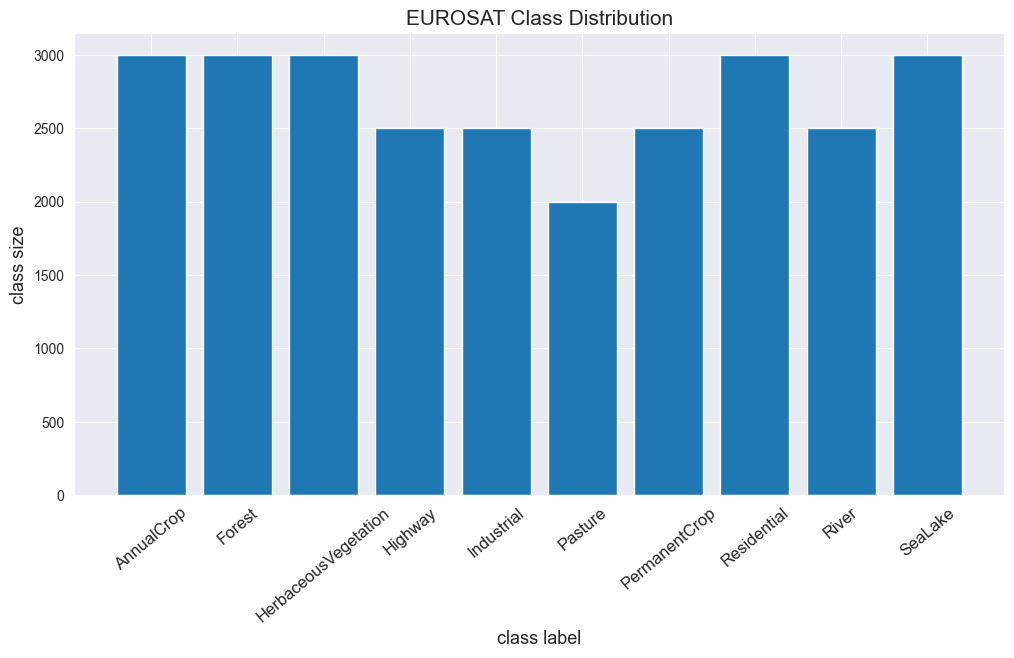

In [7]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(url, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

We can also visualize sample images from each class.

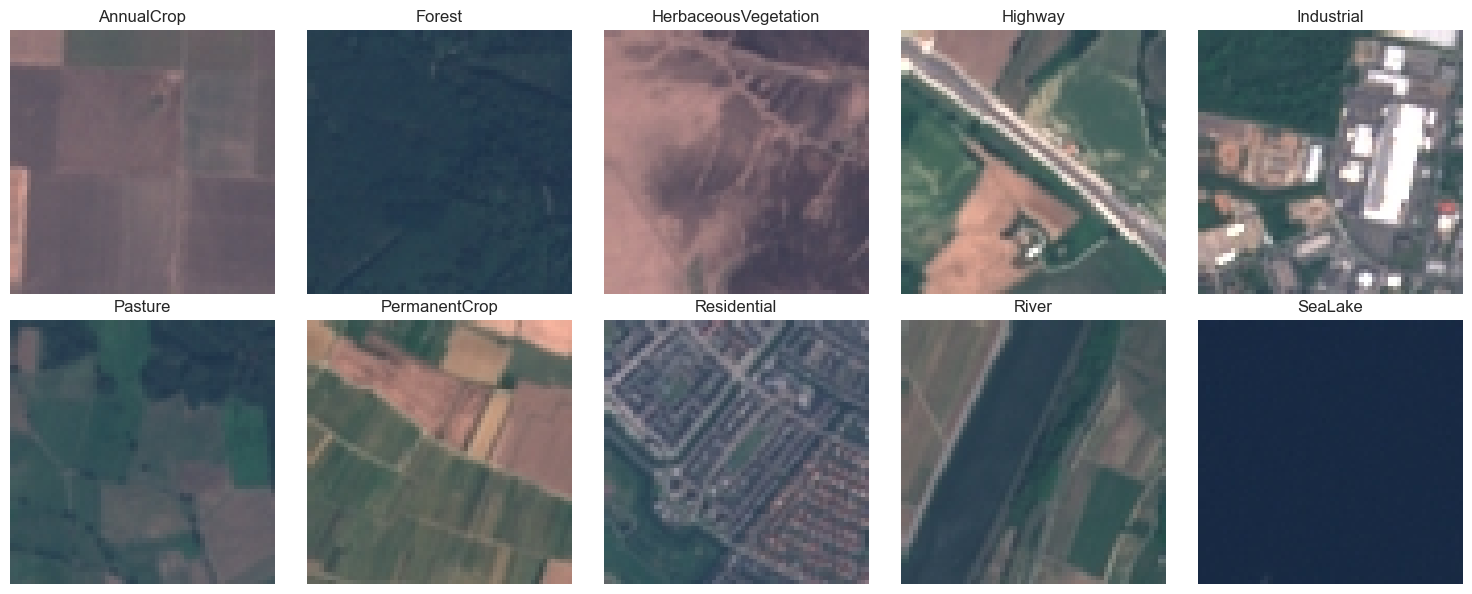

In [23]:
# plot one image from each class in a 2x5 grid
plt.figure(figsize=(15, 6))

for i, l in enumerate(labels):
    plt.subplot(2, 5, i+1)
    img = PIL.Image.open(os.path.join(url, l, os.listdir(os.path.join(url, l))[0]))
    plt.imshow(img)
    plt.title(l)
    plt.axis('off')

plt.tight_layout()
plt.show()

Now we'll import the data and split it into training and testing sets.

In [60]:
import os
import imageio.v2 as imageio
import numpy as np
from skimage import io, color

C:\Users\Nissim\Desktop\Spring 2023\Remote Sensing\MUSA-650_Spring2023\venv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


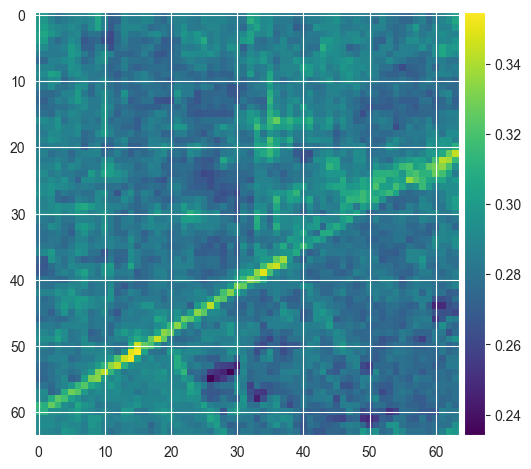

In [61]:
# Load an example image
img = io.imread("C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750/Forest/Forest_28.jpg")

# Check if the image is already grayscale
if len(img.shape) == 2 or np.allclose(img[...,0], img[...,1]) and np.allclose(img[...,0], img[...,2]):
    print('Image is already grayscale')
else:
    # Convert the image to grayscale using rgb2gray()
    gray_img = color.rgb2gray(img)
    io.imshow(gray_img)
    io.show()

In [77]:
import os
import imageio.v2 as imageio
import numpy as np
from skimage import color

# Define the subfolder names
subfolders = ['Residential', 'Industrial', 'Forest']

# Initialize empty lists for images and labels
images = []
labels = []

# Loop over subfolders
for subfolder in subfolders:
    # Get list of image filenames in the current subfolder
    subfolder_path = os.path.join(url, subfolder)
    image_filenames = os.listdir(subfolder_path)

    # Load and append each image to images list
    for image_filename in image_filenames:
        image_path = os.path.join(subfolder_path, image_filename)
        image = imageio.imread(image_path)
        # Convert image to grayscale
        gray_image = color.rgb2gray(image)
        images.append(gray_image)
        labels.append(subfolder)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [78]:
images.shape

(8500, 64, 64)

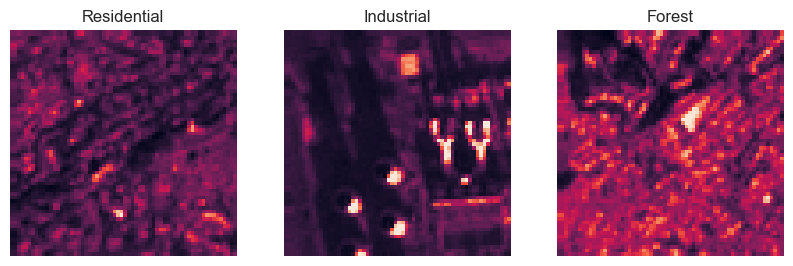

In [79]:
# print three random images from images with their labels
plt.figure(figsize=(10, 10))
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[random.randint(0, len(images))])
    plt.title(labels[random.randint(0, len(labels))])
    plt.axis("off")

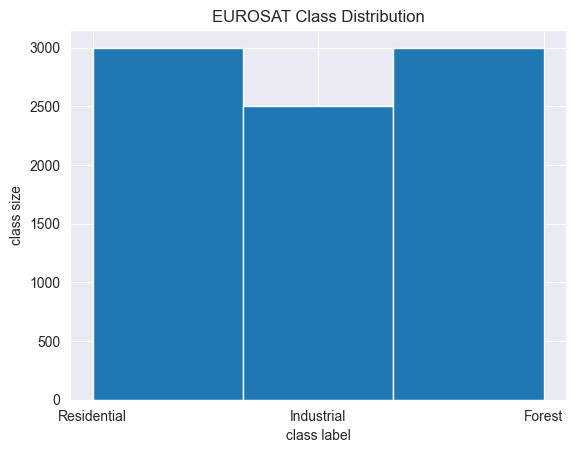

In [56]:
# plot a histogram of the distribution of labels in images
plt.hist(labels, bins=3)
plt.xticks([0, 1, 2], subfolders)
plt.xlabel('class label')
plt.ylabel('class size')
plt.title('EUROSAT Class Distribution');

Now we'll flatten the images.

In [81]:
# flatten images
images = images.reshape(images.shape[0], -1)

# print shape of images
images.shape

(8500, 4096)

#### Splitting the Data

We can now split the data into training and testing sets. We want a 60-40 split.

In [95]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.4, random_state=42)

### S2: Binary Classifiers

SVM classifier for classes ('Industrial', 'Forest') Accuracy: 0.997246443322625


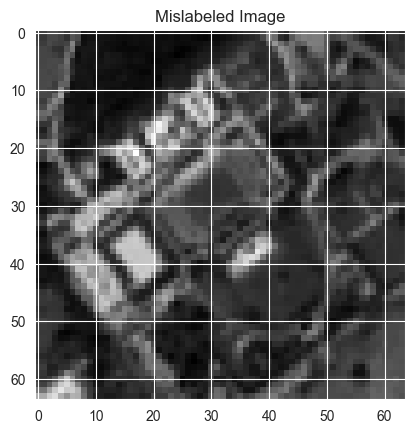

False label: Forest
True label: Industrial
SVM classifier for classes ('Industrial', 'Residential') Accuracy: 0.7421242124212422


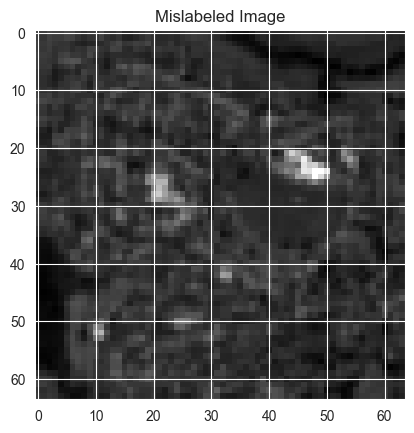

False label: Industrial
True label: Residential
SVM classifier for classes ('Forest', 'Residential') Accuracy: 0.9558149228845352


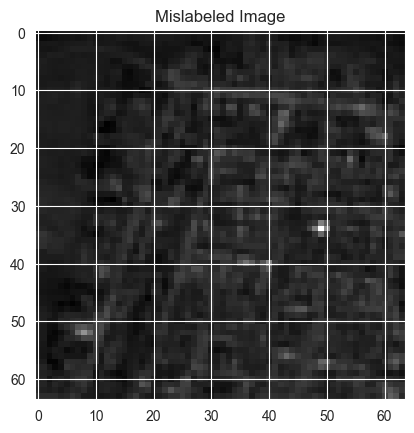

False label: Forest
True label: Residential


In [109]:
from itertools import combinations
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a list of class combinations
class_combinations = combinations(set(labels), 2)

# Train and evaluate each binary SVM classifier
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    
    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1)
    svm.fit(images_train_filtered, labels_train_filtered)
    
    # Evaluate the performance of the binary SVM classifier on the filtered test data
    y_pred = svm.predict(images_test_filtered)
    accuracy = accuracy_score(labels_test_filtered, y_pred)
    
    # Print the accuracy score for the current binary SVM classifier
    print("SVM classifier for classes", classes, "Accuracy:", accuracy)

    # Find a mislabeled image
    misclassified_idx = np.where(y_pred != labels_test_filtered)[0][0]
    misclassified_img = images_test_filtered[misclassified_idx]
    misclassified_label = y_pred[misclassified_idx]
    true_label = labels_test_filtered[misclassified_idx]

    # Plot the misclassified image
    plt.imshow(misclassified_img.reshape(64, 64), cmap='gray')
    plt.title('Mislabeled Image')
    plt.show()

    # Print the false and true labels
    print('False label: {}'.format(misclassified_label))
    print('True label: {}'.format(true_label))

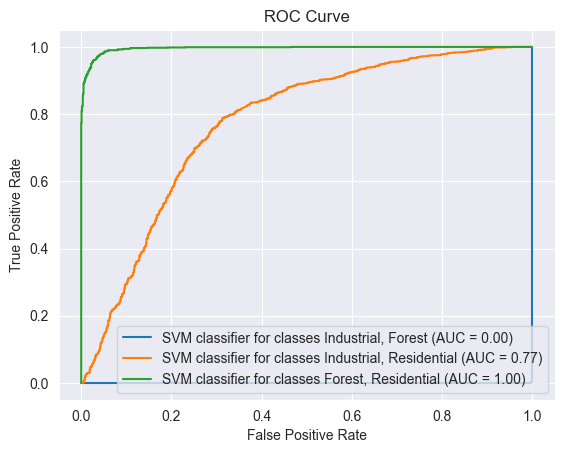

In [106]:
from itertools import combinations
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt


# Define a list of class combinations
class_combinations = combinations(set(labels), 2)

# Train and evaluate each binary SVM classifier
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    
    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1, probability=True)
    svm.fit(images_train_filtered, labels_train_filtered)

    # Calculate the probabilities of the positive class for the filtered test data
    y_prob = svm.predict_proba(images_test_filtered)[:, 1]

    # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(labels_test_filtered, y_prob, pos_label=classes[1])
    
    # Calculate the AUC for the ROC curve
    auc_score = auc(fpr, tpr)
    
    # Plot the ROC curve for the current binary SVM classifier
    plt.plot(fpr, tpr, label="SVM classifier for classes %s, %s (AUC = %.2f)" % (classes[0], classes[1], auc_score))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

# Show the ROC curve plot
plt.show()

Finally, we'll show one image that's been misclassified per class.

### S3: Multi-Class Classifiers via Majority Voting of Binary Classifiers

### S4: Multi-Class Classifiers via Random-Forest Classifier

### S5: Fully-Connected Neural Network

### S6: Variations of Network Architectures